In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from os import listdir, path
import random
from functools import partial
import resource

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import healpy as hp
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, tqdm_notebook

from data import CMB_LENS_COLS, read_cmb_lensed_img, read_cmb_lensed_folder, read_train_data, \
    get_flat_mass_distribution
from plotting import plot_map
from utils import DATA_DIR_RELATIVE, DATA_DIR_CIS, DATA_DIR_MOUNT, train_test_many_split

In [15]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80

sns.set(style='ticks')
sns.set_palette('cubehelix')

In [16]:
data_dir = DATA_DIR_RELATIVE

# Extraction of CMB lensed images

In [18]:
halo_file = path.join(data_dir, 'skyhalo_nres12r000_1M.halo.fits')
halo_data = Table.read(halo_file, format='fits').to_pandas()

In [19]:
halo_data.describe()

ID     parent_ID          Mvir         M200b         M200c  \
count  9.969430e+05  9.969430e+05  9.969430e+05  9.969430e+05  9.969430e+05   
mean   1.282383e+07  2.810160e+04  6.477373e+12  6.683837e+12  5.784889e+12   
std    7.684926e+06  4.631910e+05  1.505171e+13  1.553685e+13  1.350744e+13   
min    1.800000e+01 -1.000000e+00  7.393000e+09  4.189500e+10  0.000000e+00   
25%    6.239412e+06 -1.000000e+00  3.984000e+11  4.312700e+11  3.417300e+11   
50%    1.264300e+07 -1.000000e+00  1.820000e+12  1.951800e+12  1.574800e+12   
75%    1.889426e+07 -1.000000e+00  6.677000e+12  6.982500e+12  5.888300e+12   
max    3.010283e+07  2.095340e+07  1.365000e+15  1.459900e+15  1.144300e+15   

              M500c        M2500c           Rvir             Rs  \
count  9.969430e+05  9.969430e+05  996943.000000  996943.000000   
mean   3.801632e+12  1.116592e+12     328.773306      69.363383   
std    9.059116e+12  3.163390e+12     211.554967      81.656084   
min    0.000000e+00  0.000000e+00      41.394001       0.069000   
25%    2.365800e+11  3.368000e+10     164.009000      18.646000   
50%    1.064600e+12  2.218000e+11     280.397000      43.323002   
75%    3.859300e+12  9.537300e+11     449.353000      90.058998   
max    8.076600e+14  4.277200e+14    2475.412100    1694.892000   

              z_halo         r_halo             Vr        theta_i  \
count  996943.000000  996943.000000  996943.000000  996943.000000   
mean        0.450047    1144.467425      -3.894022       1.569506   
std         0.334956     726.079307     330.698624       0.682810   
min         0.003084       7.878484   -3413.808300       0.001794   
25%         0.181738     523.798095    -211.784600       1.044941   
50%         0.359696     992.539000      -3.186679       1.569983   
75%         0.628846    1620.625200     204.922005       2.091766   
max         3.614642    4927.302200    2735.949700       3.139799   

               phi_i        theta_s          phi_s          ipix  \
count  996943.000000  996943.000000  996943.000000  9.969430e+05   
mean        3.145586       1.569541       3.145780  1.005591e+08   
std         1.812224       0.682792       1.812145  5.807553e+07   
min         0.000000       0.001773       0.000003  1.750000e+02   
25%         1.577260       1.045044       1.577551  5.014152e+07   
50%         3.146386       1.570093       3.146765  1.005871e+08   
75%         4.711622       2.091773       4.711628  1.507673e+08   
max         6.282994       3.139595       6.283184  2.013264e+08   

            kplane+1  
count  996943.000000  
mean        8.093709  
std         4.854443  
min         1.000000  
25%         4.000000  
50%         7.000000  
75%        11.000000  
max        33.000000

In [63]:
nres = 13
NSIDE = 2 ** nres

cmb_file = path.join(data_dir, 'lensed_cmbmap_betazero_nres{}r000.fits'.format(nres))
cmb_map = hp.read_map(cmb_file)

NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


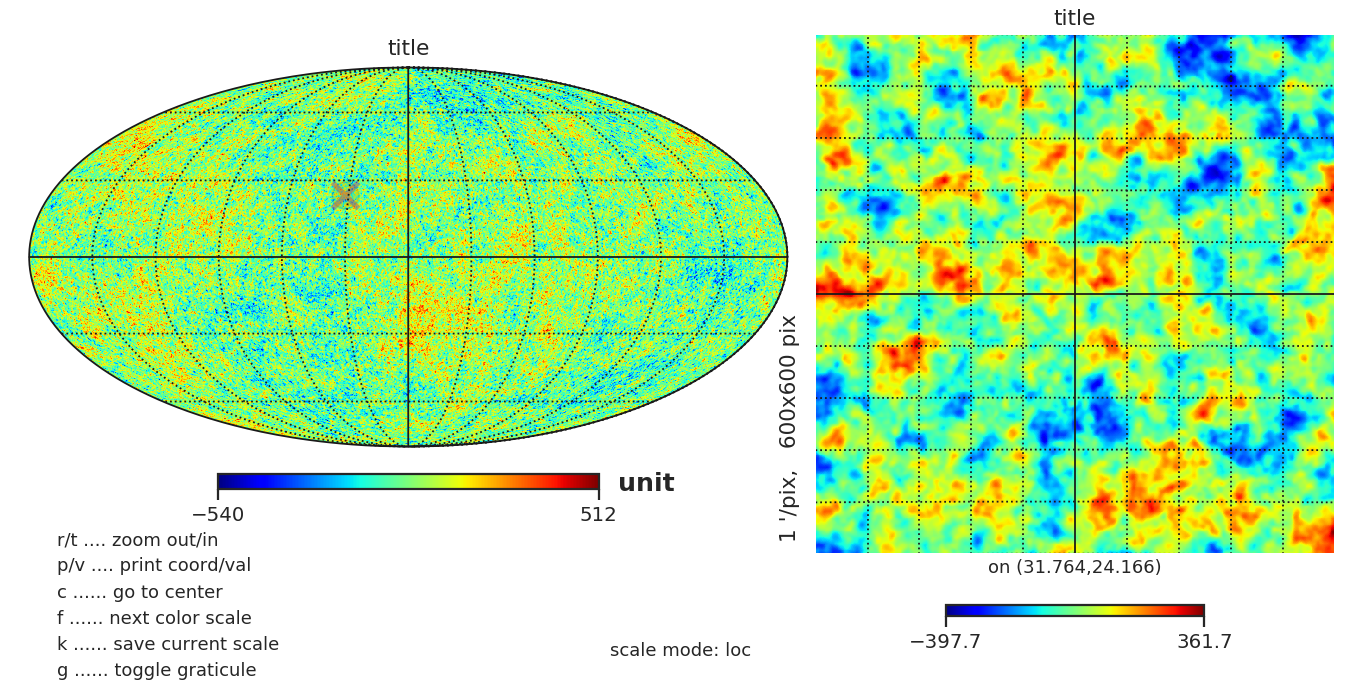

/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable functi

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


In [64]:
%matplotlib notebook
plot_map(cmb_map)

<IPython.core.display.Javascript object>


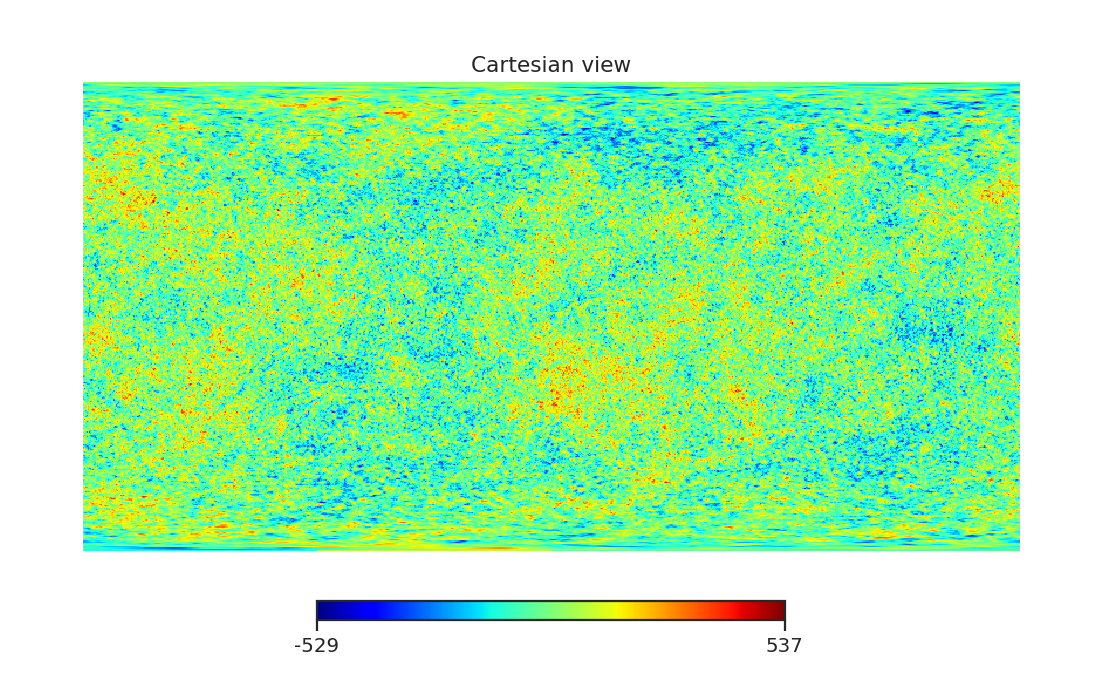

/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/home/snakoneczny/tools/anaconda3/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


In [79]:
%matplotlib notebook
hp.visufunc.cartview(map=cmb_map)

In [80]:
cmb_res = hp.pixelfunc.nside2resol(NSIDE, arcmin=True)
n_pix_x = int(24 * 60 / cmb_res)

In [96]:
projector = hp.projector.CartesianProj(xsize=n_pix_x*4)
cmb_map_projected = projector.projmap(cmb_map, partial(hp.pixelfunc.vec2pix, NSIDE))

<IPython.core.display.Javascript object>


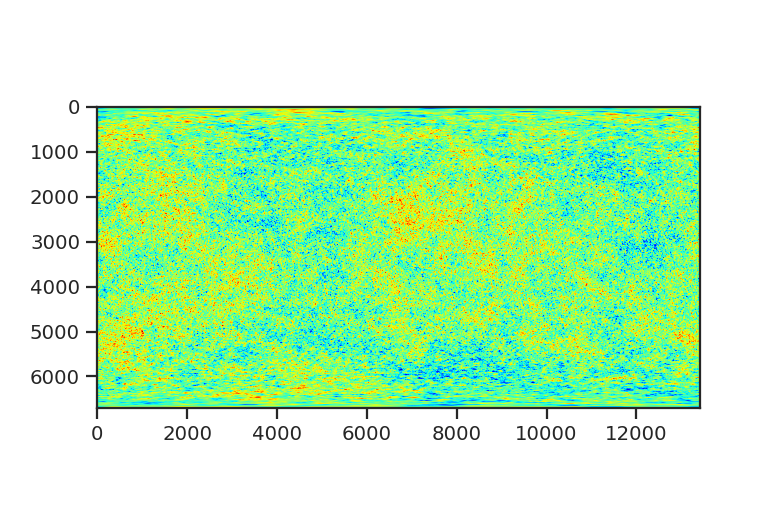

In [97]:
plt.figure()
plt.imshow(cmb_map_projected, cmap='jet', interpolation='nearest')
plt.show()

1533


<IPython.core.display.Javascript object>


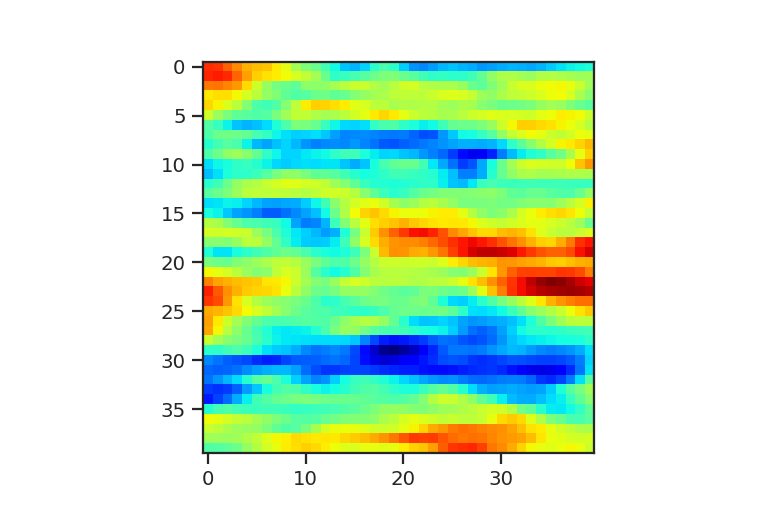

In [91]:
i_max, j_max = cmb_map_projected.shape
cut_size = 40

for index, row in tqdm_notebook(halo_data.iterrows()):
    # Get projection coordinates
    theta, phi = row['theta_i'], row['phi_i']
    x, y = projector.ang2xy(theta, phi)
    i, j = projector.xy2ij(x, y)
    
    # Continue if too close to borders to cut a full square
    if i < cut_size / 2 or j < cut_size / 2 or i > i_max - cut_size / 2 or j > j_max - cut_size / 2:
        continue
        
    # Check if not too far from poles
    if 200 < i < i_max - 200:
        continue
    
    print(i)
    
    cut_i_min = int(i - cut_size / 2)
    cut_i_max = int(i + cut_size / 2)
    cut_j_min = int(j - cut_size / 2)
    cut_j_max = int(j + cut_size / 2)
    cmb_cut = cmb_map_projected[cut_i_min: cut_i_max, cut_j_min: cut_j_max]

    plt.figure()
    plt.imshow(cmb_cut, cmap='jet', interpolation='nearest')
    plt.show()
    break

3385


<IPython.core.display.Javascript object>


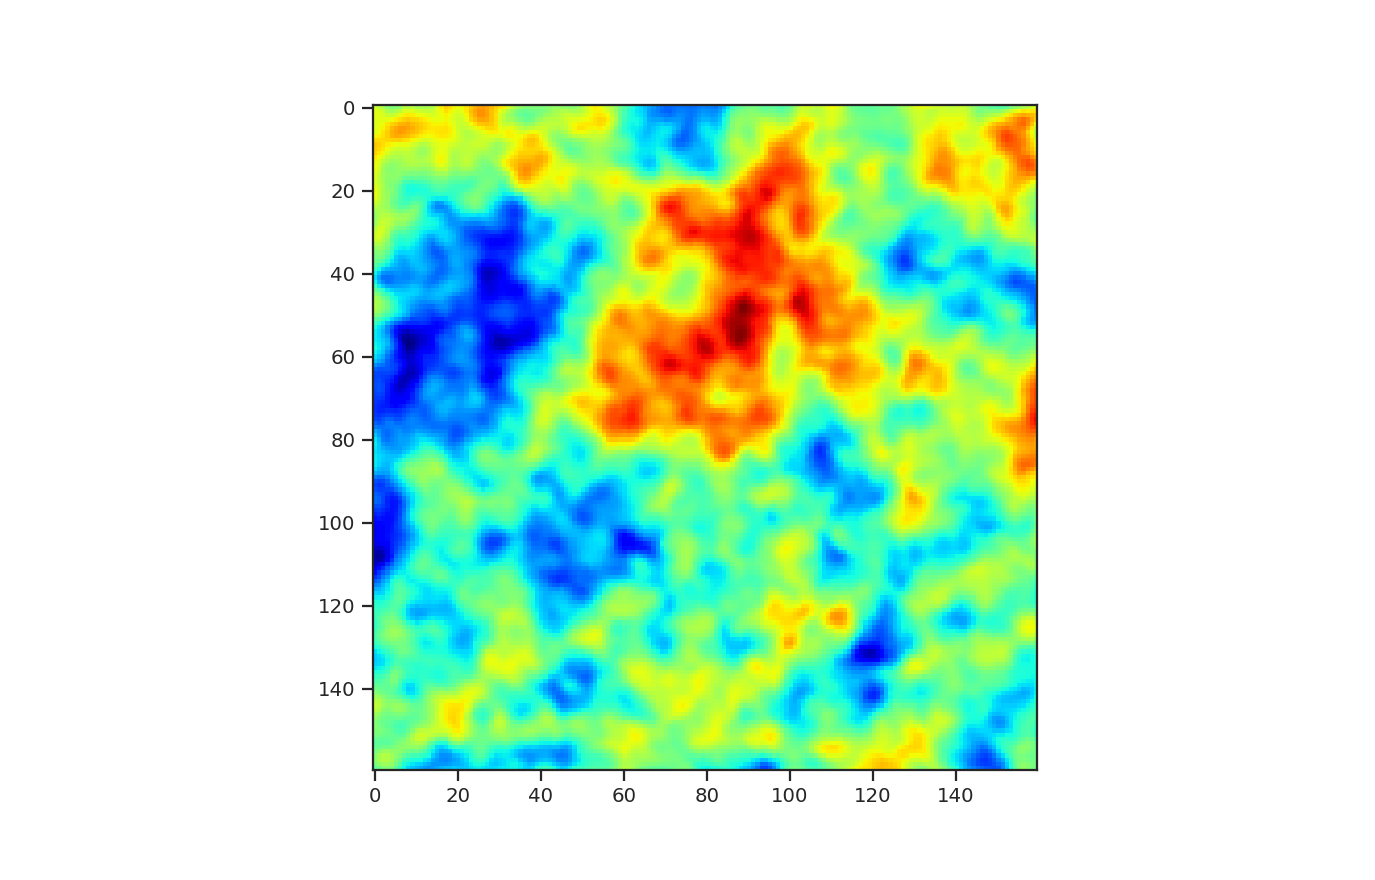

In [98]:
i_max, j_max = cmb_map_projected.shape
cut_size = 160

for index, row in tqdm_notebook(halo_data.iterrows()):
    # Get projection coordinates
    theta, phi = row['theta_i'], row['phi_i']
    x, y = projector.ang2xy(theta, phi)
    i, j = projector.xy2ij(x, y)
    
    # Continue if too close to borders to cut a full square
    if i < cut_size / 2 or j < cut_size / 2 or i > i_max - cut_size / 2 or j > j_max - cut_size / 2:
        continue
        
    # Check if not too far from equator
    if not (i_max / 2 - 800 < i < i_max / 2 + 800):
        continue
    
    print(i)
    
    cut_i_min = int(i - cut_size / 2)
    cut_i_max = int(i + cut_size / 2)
    cut_j_min = int(j - cut_size / 2)
    cut_j_max = int(j + cut_size / 2)
    cmb_cut = cmb_map_projected[cut_i_min: cut_i_max, cut_j_min: cut_j_max]

    plt.figure()
    plt.imshow(cmb_cut, cmap='jet', interpolation='nearest')
    plt.show()
    break

# Get file base of all CMB images

In [46]:
folder = '/users/snakoneczny/data/lensing_takahashi_17/cmb_lens_imgs'

output_file = '/users/snakoneczny/workspace/cmb_lensing/file_base/file_base.csv'
file_base = pd.DataFrame(columns=all_cols)

all_cols = ['file_name'] + CMB_LENS_COLS

In [55]:
# MacOS requirements for number of open files
n_img = 20000
resource.setrlimit(resource.RLIMIT_NOFILE, (n_img + 10, -1))

file_list = listdir(folder)
n_img_read = 0
for i, file_name in enumerate(tqdm_notebook(file_list, desc='Reading data')):

    if not file_base['file_name'].str.contains(file_name).any():
        n_img_read += 1

        file_path = join(folder, file_name)
        img, img_info = read_cmb_lensed_img(file_path)

        img_info['file_name'] = file_name

        file_base = file_base.append(img_info, ignore_index=True)
    
    if n_img_read >= n_img:
        print('Rerun the cell!')
        break

In [61]:
print(file_base.shape)  # 45670

(45670, 9)


In [60]:
# TODO: check if "unnamed: 0" column is present
file_base.to_csv(output_file, index=False)

# Flat mass distribution on file base

In [94]:
file_base = pd.read_csv('/users/snakoneczny/workspace/cmb_lensing/file_base/file_base.csv')

In [95]:
files_flat, y_flat = get_flat_mass_distribution(file_base_2['file_name'], file_base_2['M500c'], n_bins=100, max_bin_size=100)
print(files_flat.shape)

(2923,)


In [106]:
file_path = '/users/snakoneczny/workspace/cmb_lensing/file_base/mflat_nbins=100_binsize=100'
np.savetxt(file_path, files_flat.values, fmt='%s')

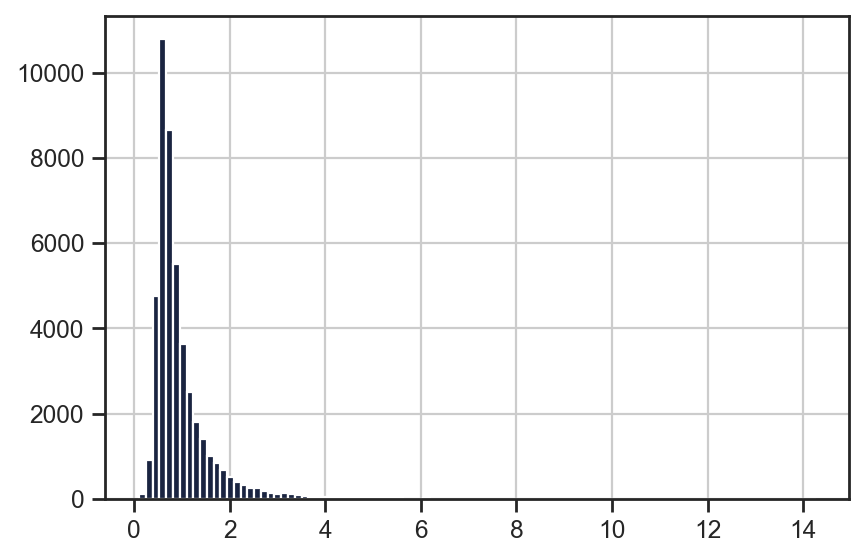

In [96]:
file_base['M500c'].hist(bins=100)

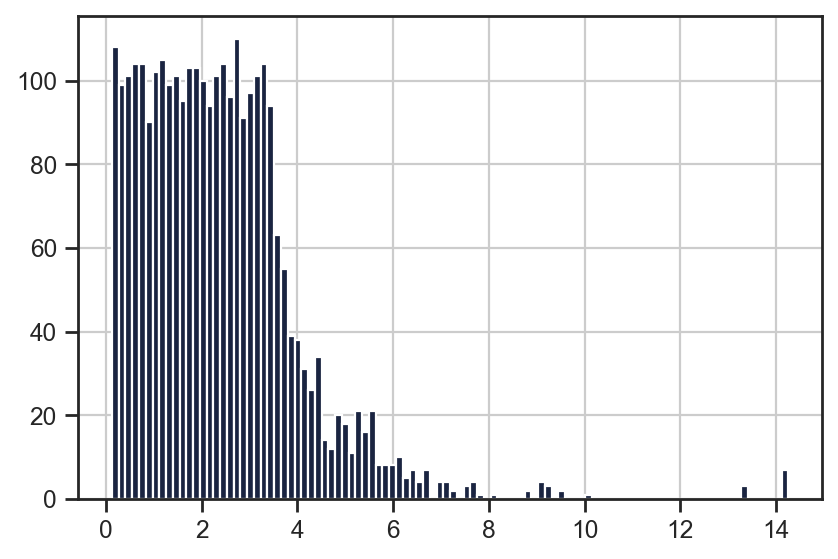

In [97]:
y_flat.hist(bins=100)

# Flat mass distribution

In [5]:
X, y = read_train_data('/users/snakoneczny/data/lensing_takahashi_17/cmb_lens_imgs', n_img=20000, col_y='M500c')
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(X.shape)

Reading data: 100%|██████████| 20000/20000 [01:39<00:00, 200.48it/s]


(20000, 40, 40, 1)


In [6]:
X_flat, y_flat = get_flat_mass_distribution(X, y, n_bins=100, max_bin_size=100)
print(X_flat.shape)

(2371, 40, 40, 1)


In [13]:
X_flat_log, y_flat_log = get_flat_mass_distribution(X, np.log(y), n_bins=100, max_bin_size=100)
print(X_flat.shape)

(2371, 40, 40, 1)


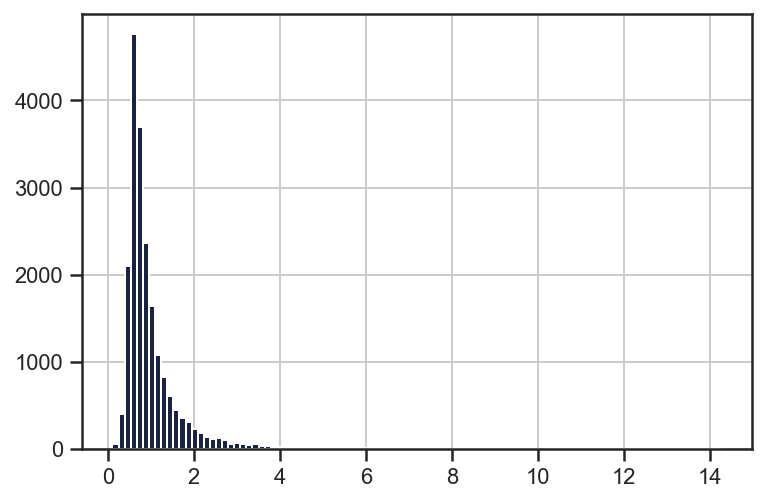

In [14]:
pd.Series(y).hist(bins=100)

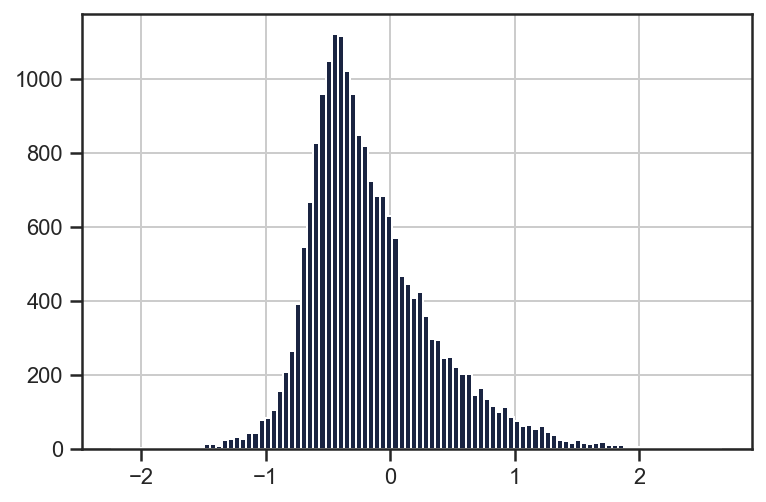

In [15]:
pd.Series(np.log(y)).hist(bins=100)

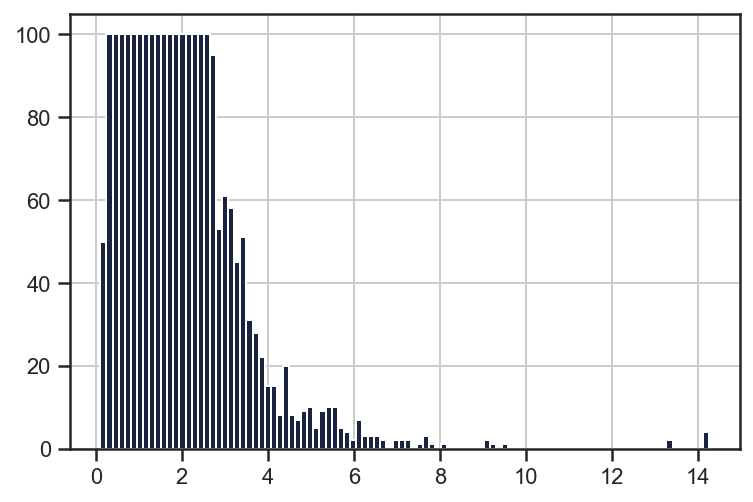

In [16]:
pd.Series(y_flat).hist(bins=100)

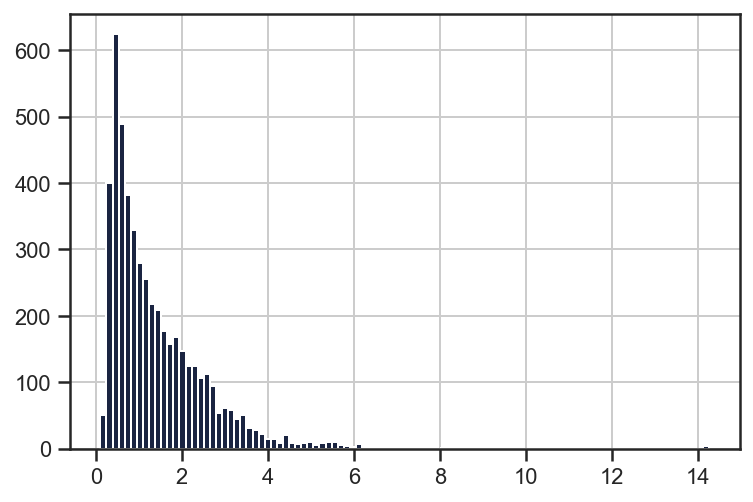

In [18]:
pd.Series(np.exp(y_flat_log)).hist(bins=100)

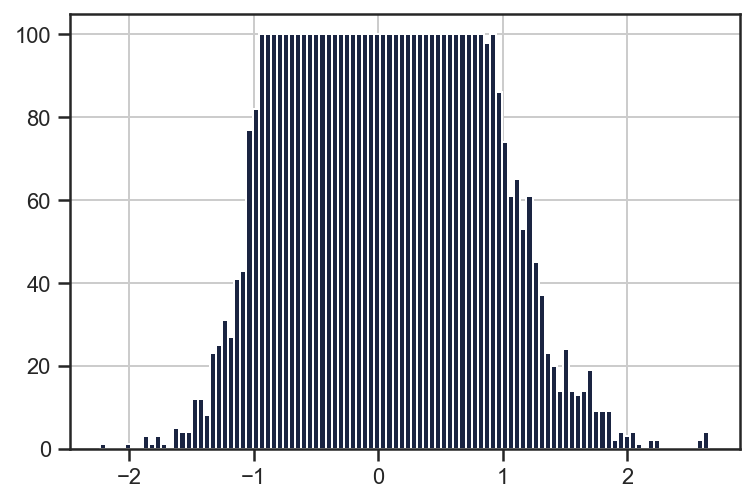

In [17]:
pd.Series(y_flat_log).hist(bins=100)

# Redshift and mass

In [4]:
data = read_cmb_lensed_folder('/users/snakoneczny/data/lensing_takahashi_17/cmb_lens_imgs', n_img=20000)

Reading data: 100%|██████████| 20000/20000 [02:33<00:00, 130.44it/s]


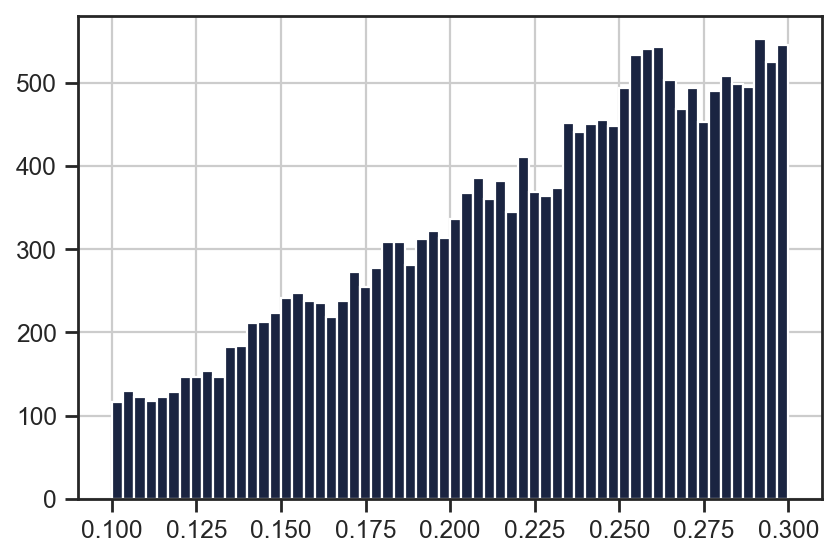

In [7]:
data['Redshift'].hist(bins=60)
# plt.xlim(xmax=8)

In [5]:
data.loc[data['Redshift'] < 0.2].describe()

M200b        M200c        M500c         Mvir   Ngrid  \
count  6414.000000  6414.000000  6414.000000  6414.000000  6414.0   
mean      1.993334     1.488964     0.998665     1.805464    40.0   
std       1.482797     1.154954     0.795796     1.361822     0.0   
min       1.000200     0.380440     0.107380     0.613100    40.0   
25%       1.201225     0.899300     0.604140     1.087000    40.0   
50%       1.529000     1.136550     0.773170     1.381500    40.0   
75%       2.209575     1.651500     1.108725     2.006000    40.0   
max      27.864000    20.162000    14.256000    24.890000    40.0   

           R_scale     Redshift  pix_size  
count  6414.000000  6414.000000    6414.0  
mean      0.272688     0.158855       0.5  
std       0.153503     0.027467       0.0  
min       0.069532     0.100002       0.5  
25%       0.178868     0.138360       0.5  
50%       0.233097     0.161919       0.5  
75%       0.314498     0.182565       0.5  
max       1.536595     0.199991       0.5

In [6]:
data.loc[data['Redshift'] > 0.2].describe()

M200b         M200c         M500c          Mvir    Ngrid  \
count  13586.000000  13586.000000  13586.000000  13586.000000  13586.0   
mean       1.894110      1.465947      0.979353      1.744161     40.0   
std        1.246529      0.989554      0.675642      1.157923      0.0   
min        1.000000      0.380050      0.174150      0.649600     40.0   
25%        1.176000      0.910450      0.609270      1.082000     40.0   
50%        1.469050      1.134500      0.765775      1.350000     40.0   
75%        2.078750      1.615725      1.089300      1.915000     40.0   
max       16.949000     14.312000      9.512800     16.070000     40.0   

            R_scale      Redshift  pix_size  
count  13586.000000  13586.000000   13586.0  
mean       0.290873      0.253741       0.5  
std        0.158281      0.028294       0.0  
min        0.083795      0.200001       0.5  
25%        0.192942      0.230760       0.5  
50%        0.250432      0.255634       0.5  
75%        0.337154      0.278170       0.5  
max        1.721934      0.299997       0.5

(-0.34320000000000017, 8)

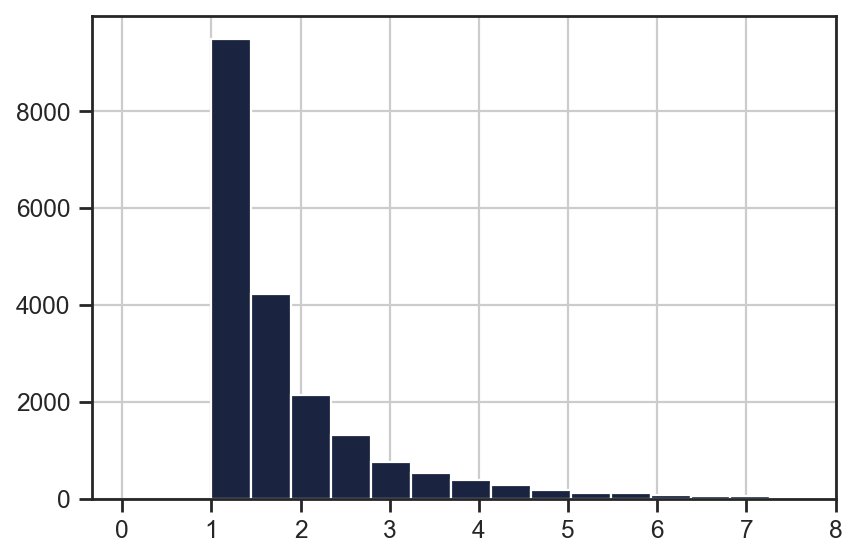

In [5]:
data['M200b'].hist(bins=60)
plt.xlim(xmax=8)

(-0.6000510000000001, 6)

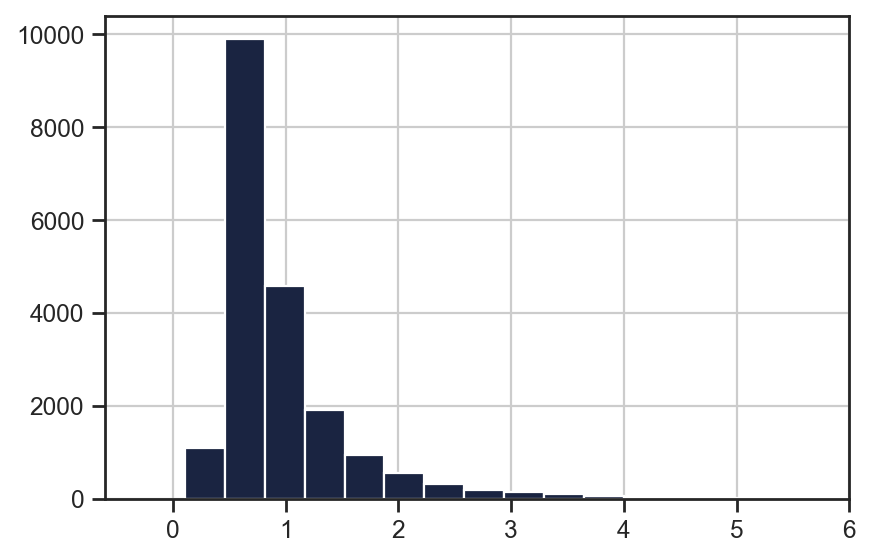

In [6]:
data['M500c'].hist(bins=40)
plt.xlim(xmax=6)

# Errors from mean values

In [7]:
# MSE when predicting mean values
masses = ['M200b', 'M500c']
for mass in masses:
    mean = data[mass].mean()
    mse = mean_squared_error(data[mass], [mean] * data.shape[0])
    print('MSE when estimating mean {} value: {:.4f}'.format(mass, mse))

MSE when estimating mean M200b value: 1.7626
MSE when estimating mean M500c value: 0.5132


In [8]:
# Mean values MSE with mass relevant train-test split
_, y_test_low, y_test_high, y_test_random =\
    train_test_many_split(data['M500c'], side_test_size=0.05, random_test_size=0.1)
to_pred = [
    ('random', y_test_random),
    ('low', y_test_low),
    ('high', y_test_high),
]
for mass in masses:
    for test_name, y_test in to_pred:
        mean = y_test.mean()
        mse = mean_squared_error(y_test, [mean] * len(y_test))
        print('MSE when estimating mean {} value on {} test: {:.4f}'.format(mass, test_name, mse))

MSE when estimating mean M200b value on random test: 0.1334
MSE when estimating mean M200b value on low test: 0.0041
MSE when estimating mean M200b value on high test: 1.8975
MSE when estimating mean M500c value on random test: 0.1334
MSE when estimating mean M500c value on low test: 0.0041
MSE when estimating mean M500c value on high test: 1.8975


/Users/snakoneczny/workspace/cmb_lensing/utils.py:94: FutureWarning: Series.flags is deprecated and will be removed in a future version
  indices = indices if indices.flags.writeable else indices.copy()


# Provided CMB lensed images

In [35]:
def plot_cmb_imgs(imgs_df):
    # Make plot adjusted for a grid of square images
    n_img = 80
    width = 20
    n_cols = 4
    fig = plt.figure(figsize=(width, n_img / n_cols / n_cols * width))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    mpl.rcParams['image.cmap'] = 'jet'

    # Read and plot images in a grid
    for i, (_, row) in enumerate(imgs_df.iterrows()):
        
        if i == n_img:
            break

        # Calculate image extent
        gsize = row['pix_size']
        nside = row['Ngrid']
        min = -0.5 * gsize * nside
        max = +0.5 * gsize * nside
        extent = (min, max, min, max)

        # Plot image in a proper grid cell
        ax = fig.add_subplot(n_img / n_cols, n_cols, i + 1)
        ax.imshow(row['image'], extent=extent)
    #     ax.set_xlabel('(arcmin)')
    #     ax.set_ylabel('(arcmin)')

        # Add title with halo information
        title = 'M200b: {:.4f}, M500c: {:.4f}, z: {:.4f}'.format(row['M200b'], row['M500c'], row['Redshift'])
        ax.set_title(title)

In [13]:
data = read_cmb_lensed_folder('/mnt/home/snakoneczny/data/lensing_takahashi_17/cut_nres13_r000_fits', n_img=350)

In [22]:
width = 0.17  # 10 degrees
top_pole = width
bottom_pole = 3.14 - width
top_equator = 3.14 / 2 - width
bottom_equator = 3.14 / 2 + width

data_poles = data.loc[(data['theta_i'] < top_pole) | (data['theta_i'] > bottom_pole)]
data_equator = data.loc[(data['theta_i'] > top_equator) & (data['theta_i'] < bottom_equator)]

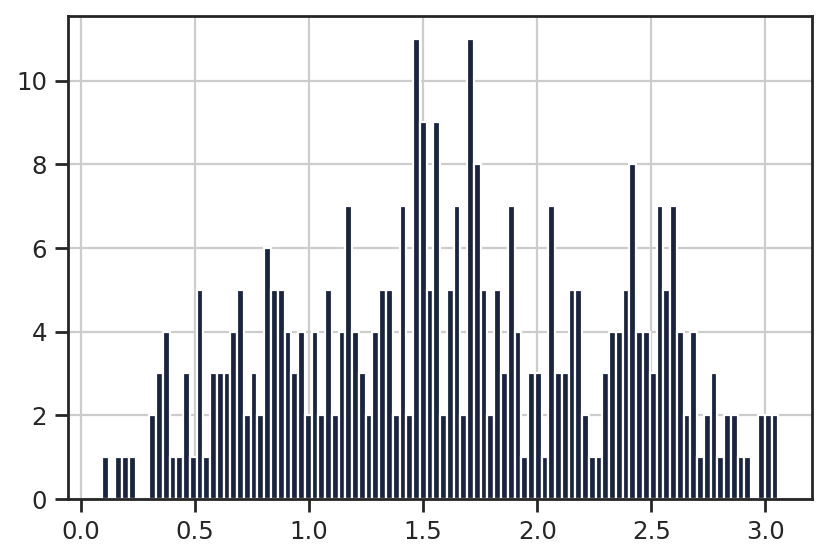

In [11]:
data['theta_i'].hist(bins=100)

In [23]:
print(data.shape)
print(data_poles.shape)
print(data_equator.shape)

(350, 11)
(8, 11)
(72, 11)


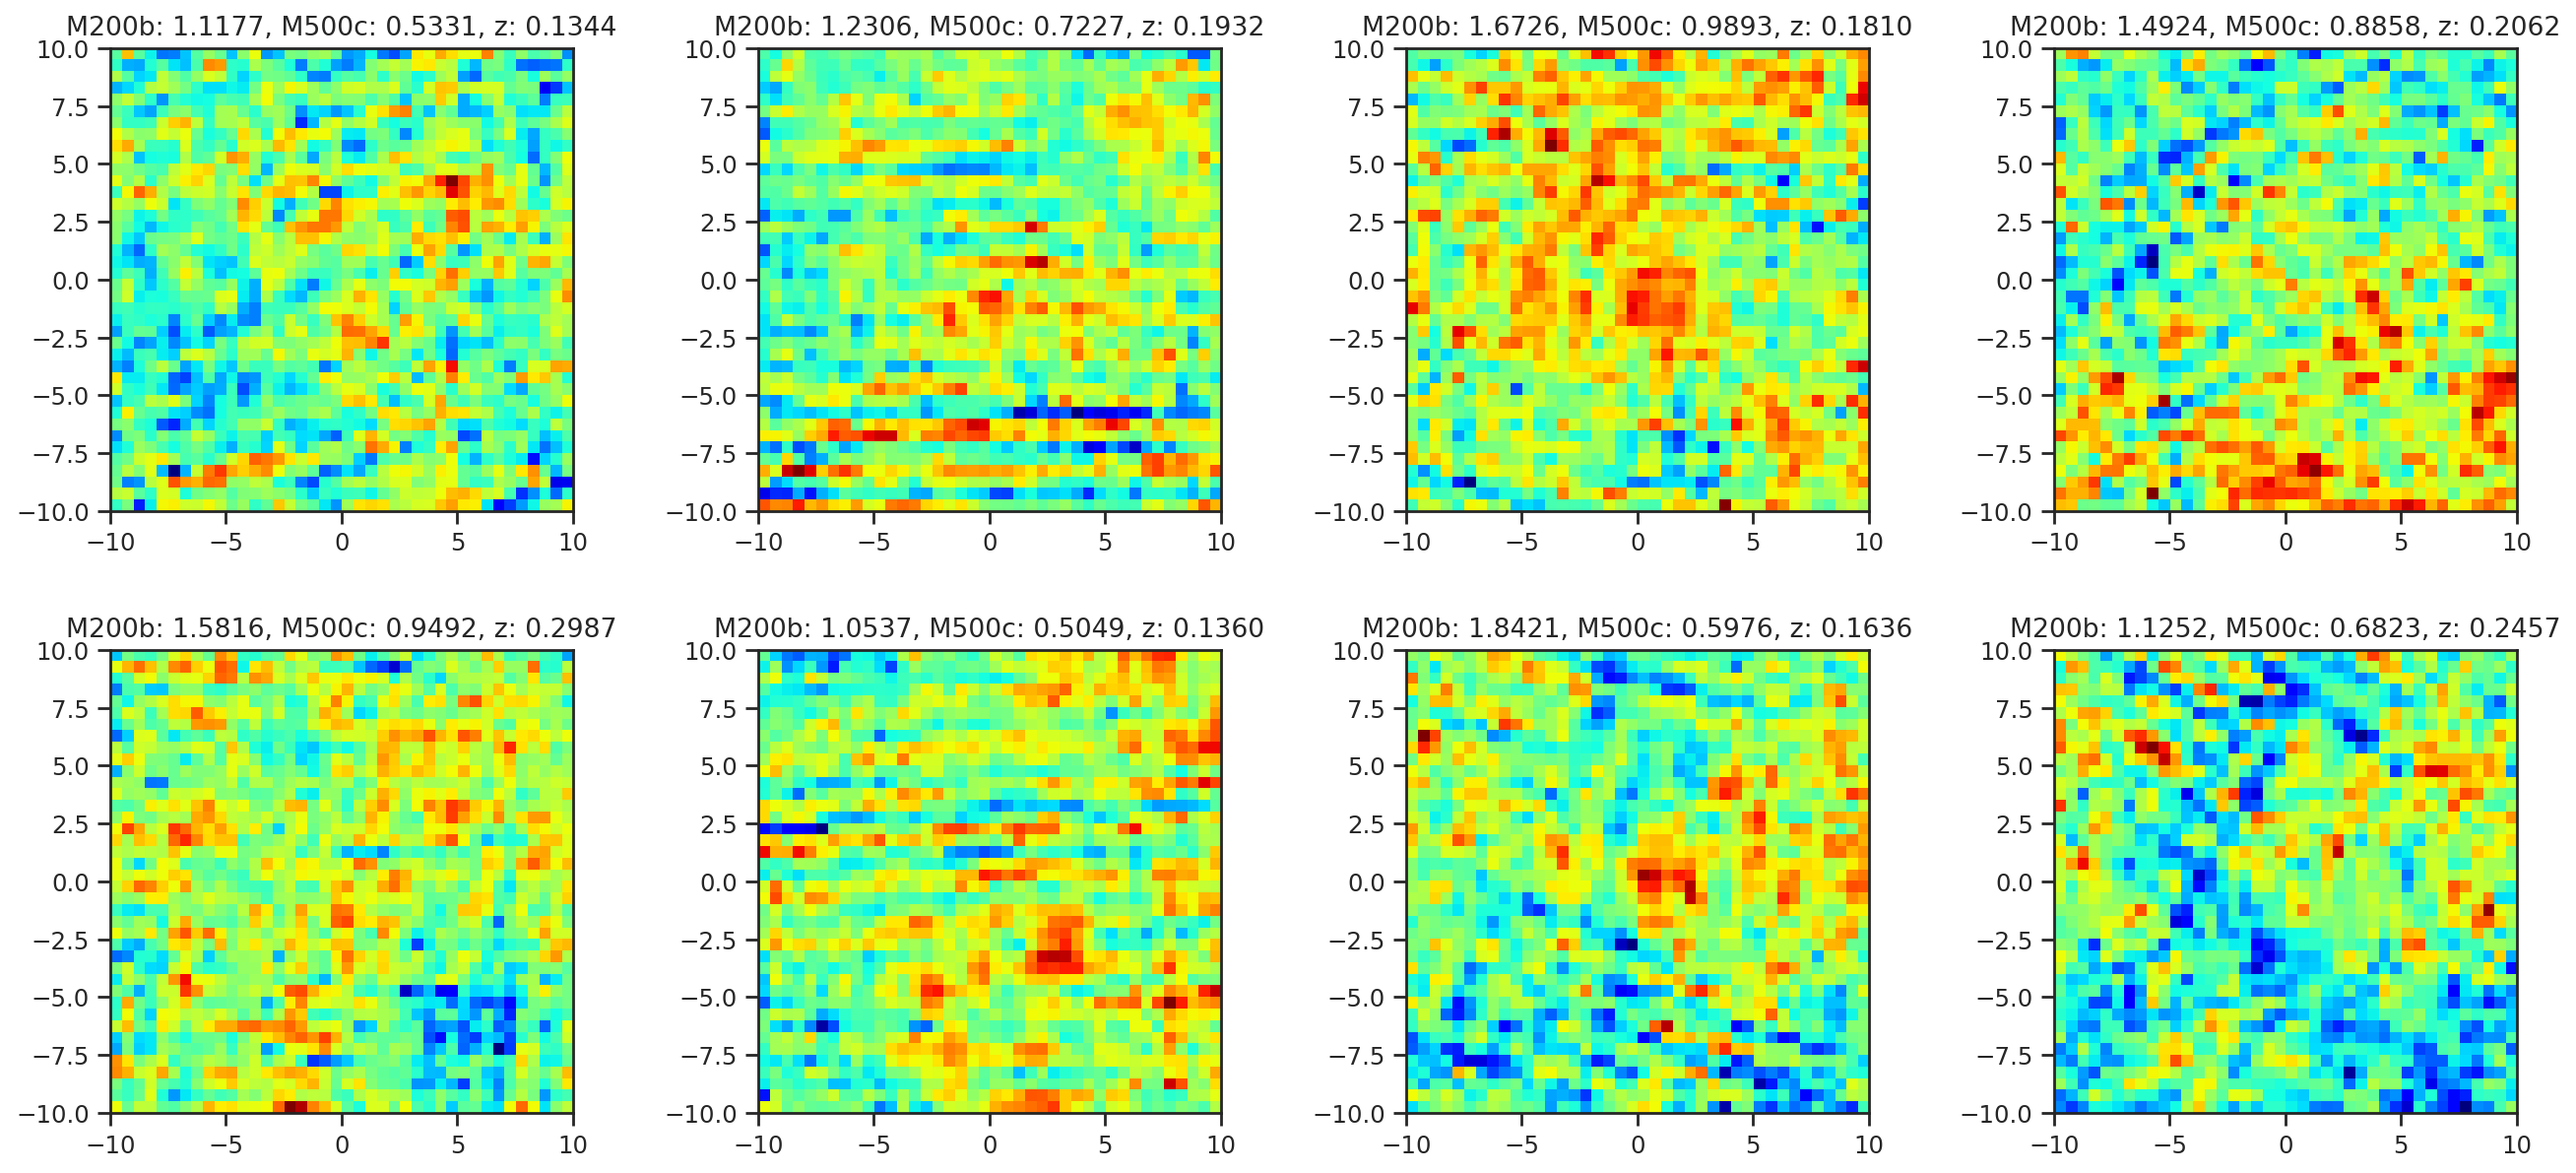

In [36]:
plot_cmb_imgs(data_poles)

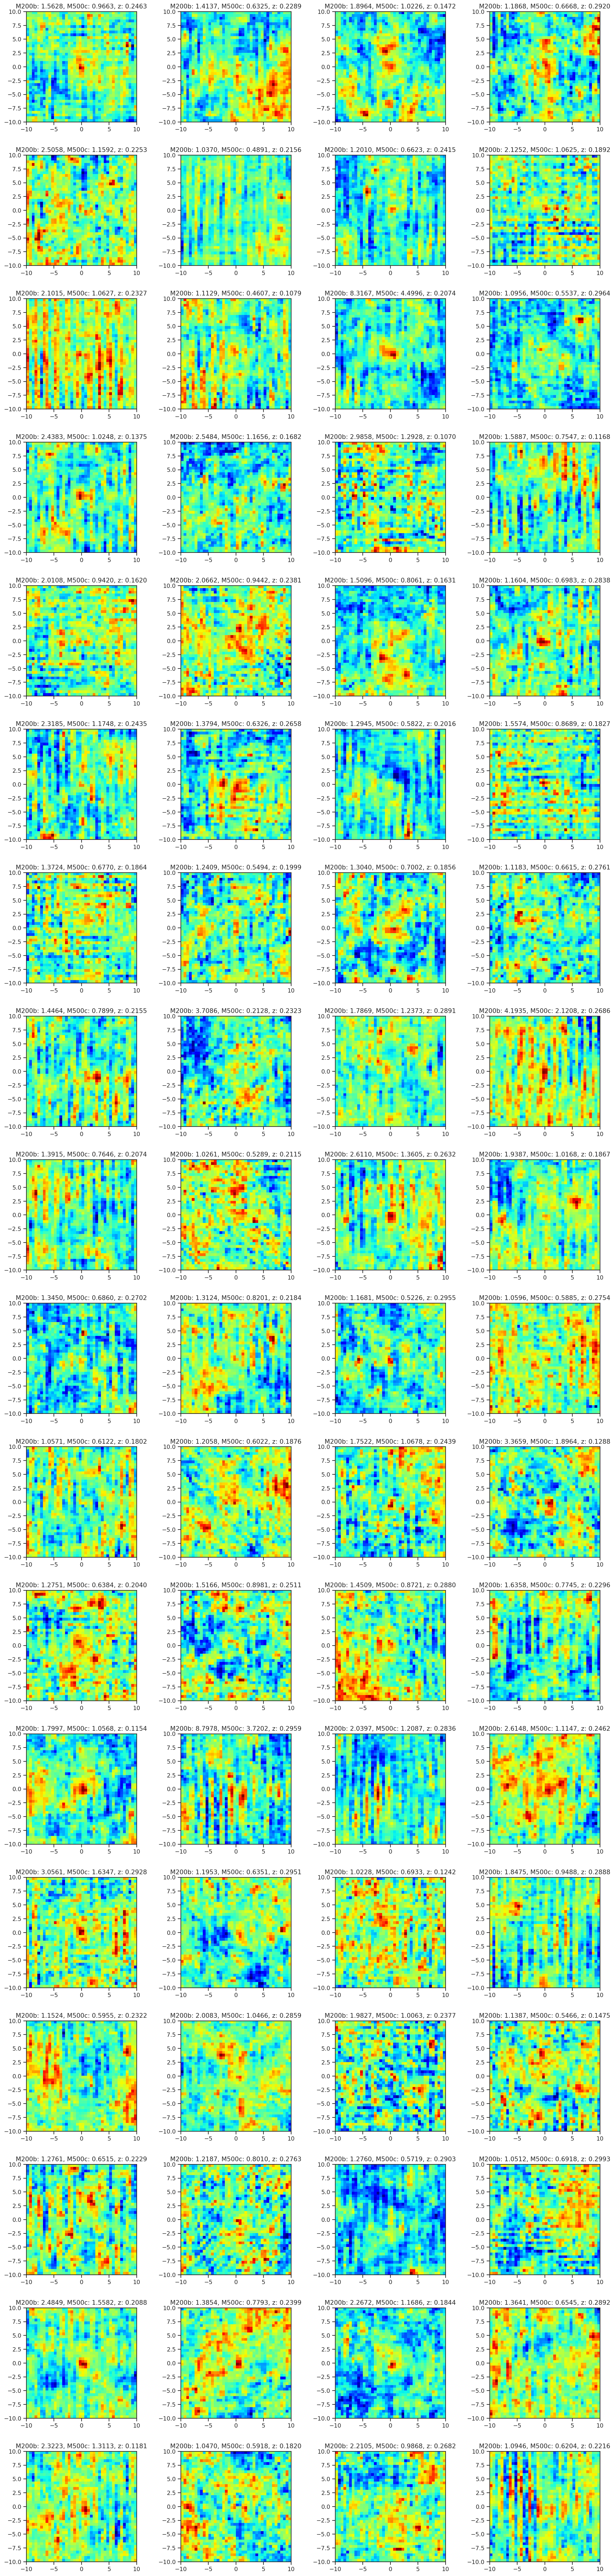

In [37]:
plot_cmb_imgs(data_equator)

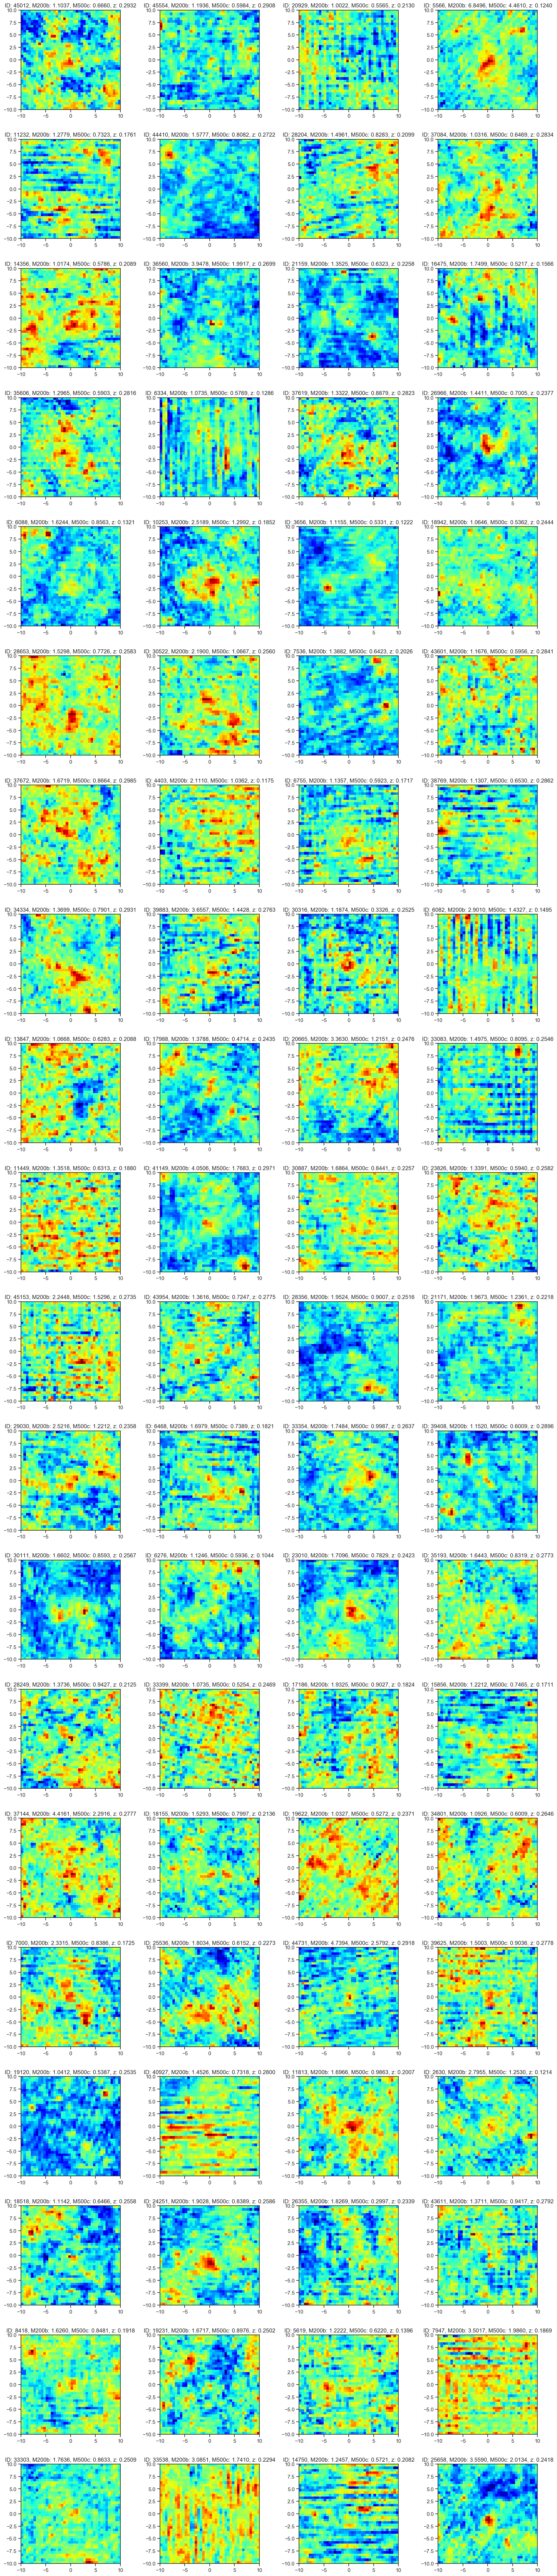

In [22]:
# nres13 r054

# random.seed(1456)
# n_img = 80
# file_list_subset = random.sample(file_list, n_img)

plot_cmb_imgs(file_list)